<img src="logo_ue.png" width="400"/>


# ANEXO 5
# 3. DESARROLLO DEL PROYECTO - 
## Clusters

In [1]:
import pandas as pd
import numpy as np
import re
import ast
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import skfuzzy as fuzz
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
df_iniciativas = pd.read_excel("iniciativas_preprocesadas.xlsx")
df_proyectos = pd.read_excel("proyectos_preprocesados.xlsx")
#df_iniciativas = df_iniciativas.head(10000).copy()  
#df_proyectos = df_proyectos.head(100).copy()  

In [3]:
# ===========================================
# 2. Preprocesamiento de texto y DANE
# ===========================================

def convertir_a_lista_codigos(texto):
    if pd.isna(texto):
        return []
    return re.findall(r"\d{5}", str(texto))

def normalizar_codigos(campo):
    if pd.isna(campo):
        return []
    elif isinstance(campo, list):
        return [str(x).zfill(5) for x in campo]
    elif isinstance(campo, str):
        try:
            lista = ast.literal_eval(campo)
            return [str(x).zfill(5) for x in lista] if isinstance(lista, list) else [str(lista).zfill(5)]
        except:
            return [campo.zfill(5)]
    elif isinstance(campo, (int, float)):
        return [str(int(campo)).zfill(5)]
    return []

df_iniciativas["codigos_dane_list"] = df_iniciativas["codigosdane"].apply(normalizar_codigos)
df_proyectos["codigos_dane_list"] = df_proyectos["codigoentidadnormalizado"].apply(normalizar_codigos)

# Combinar 'pilar' con texto y tokenizar
df_iniciativas["texto_completo"] = df_iniciativas["pilar"].fillna("") + " " + df_iniciativas["texto_preprocesado"]
df_iniciativas["tokens"] = df_iniciativas["texto_completo"].fillna("").apply(lambda x: x.split())
df_proyectos["tokens"] = df_proyectos["texto_preprocesado"].fillna("").apply(lambda x: x.split())

# Filtrar textos muy cortos
df_iniciativas = df_iniciativas[df_iniciativas["tokens"].apply(len) >= 5].reset_index(drop=True)



In [4]:
# ===========================================
# 3. Entrenamiento Word2Vec y reducción PCA
# ===========================================
corpus_total = df_iniciativas["tokens"].tolist() + df_proyectos["tokens"].tolist()
modelo_w2v = Word2Vec(sentences=corpus_total, vector_size=100, window=3, min_count=1, sg=1, seed=42)

def vector_promedio(tokens, modelo, dim=100):
    vectores = [modelo.wv[token] for token in tokens if token in modelo.wv]
    return np.mean(vectores, axis=0) if vectores else np.zeros(dim)

df_iniciativas["vector"] = df_iniciativas["tokens"].apply(lambda x: vector_promedio(x, modelo_w2v))
df_proyectos["vector"] = df_proyectos["tokens"].apply(lambda x: vector_promedio(x, modelo_w2v))

# Normalizar y reducir dimensión
vectores = np.vstack(df_iniciativas["vector"].values)
vectores_norm = normalize(vectores, norm='l2')
pca = PCA(n_components=50, random_state=42)
vectores_reducidos = pca.fit_transform(vectores_norm)


📋 Tabla resumen FPC + Silhouette Score:
    N_clusters  Fuzzy Partition Coefficient (FPC)  Silhouette Score
0            2                             0.5198            0.1491
1            3                             0.4234            0.1697
2            4                             0.3674            0.1901
3            5                             0.3117            0.1181
4            6                             0.2108            0.1037
5            7                             0.1817            0.0680
6            8                             0.1593           -0.0223
7            9                             0.1416            0.0367
8           10                             0.1272            0.0058
9           11                             0.1474            0.0835
10          12                             0.1054            0.0204


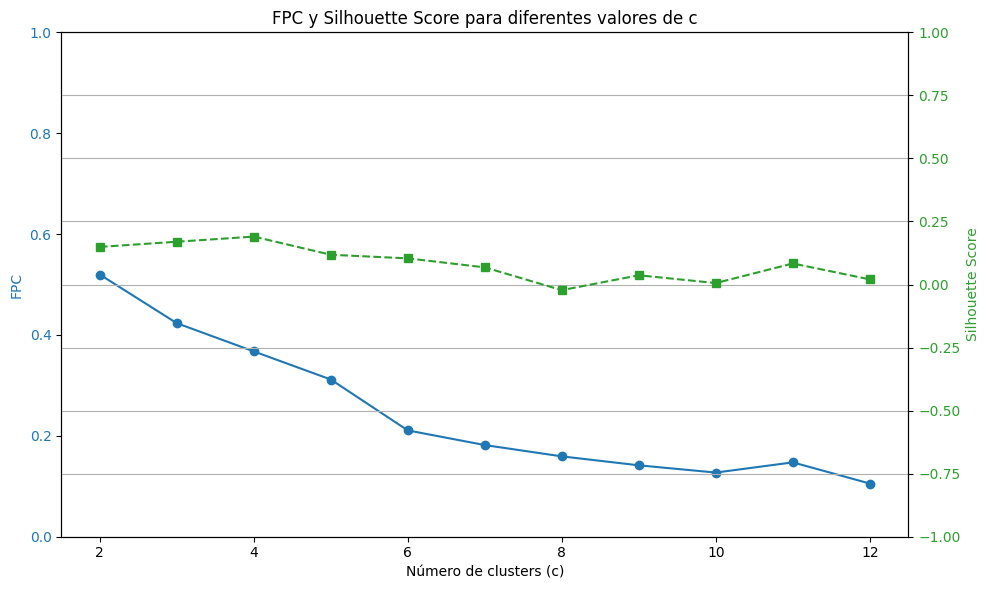

In [5]:
# ===========================================
# 4. Evaluación de FCM para distintos c
# ===========================================
fpc_values = []
silhouette_values = []
cluster_range = list(range(2, 13))
X_T = vectores_reducidos.T

for c in cluster_range:
    try:
        cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(X_T, c=c, m=1.5, error=0.005, maxiter=1000, seed=42)
        fpc_values.append(fpc)
        cluster_labels = np.argmax(u, axis=0)
        score = silhouette_score(vectores_reducidos, cluster_labels) if len(set(cluster_labels)) > 1 else np.nan
        silhouette_values.append(score)
    except Exception as e:
        fpc_values.append(np.nan)
        silhouette_values.append(np.nan)


# Tabla resumen
tabla_metricas = pd.DataFrame({
    "N_clusters": cluster_range,
    "Fuzzy Partition Coefficient (FPC)": np.round(fpc_values, 4),
    "Silhouette Score": np.round(silhouette_values, 4)
})

print("\n📋 Tabla resumen FPC + Silhouette Score:")
print(tabla_metricas)

# Gráfico
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Número de clusters (c)')
ax1.set_ylabel('FPC', color=color)
ax1.plot(cluster_range, fpc_values, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(cluster_range, silhouette_values, marker='s', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-1, 1)

plt.title('FPC y Silhouette Score para diferentes valores de c')
fig.tight_layout()
plt.grid(True)
plt.show()


📋 Tabla resumen FCM con c=4
   Cluster  N_iniciativas  Pertenencia_promedio      Desv       Min       Max
0        0            550              0.250027  0.000011  0.250002  0.250058
1        1          11962              0.250275  0.000142  0.250002  0.250664
2        2          18344              0.250265  0.000169  0.250002  0.250781
3        3           2151              0.250049  0.000024  0.250003  0.250120


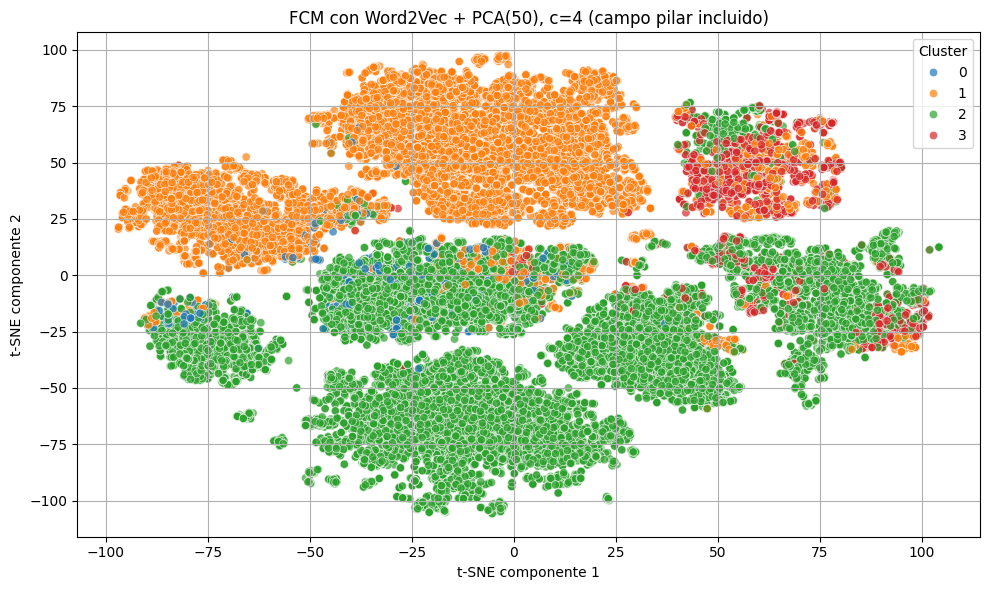


📋 Tabla resumen FCM con c=5
   Cluster  N_iniciativas  Pertenencia_promedio      Desv       Min       Max
0        0            115              0.200019  0.000009  0.200004  0.200045
1        1          11963              0.200360  0.000184  0.200002  0.200900
2        2          17990              0.200245  0.000150  0.200004  0.200730
3        3           1407              0.200047  0.000016  0.200004  0.200092
4        4           1532              0.200066  0.000033  0.200006  0.200197


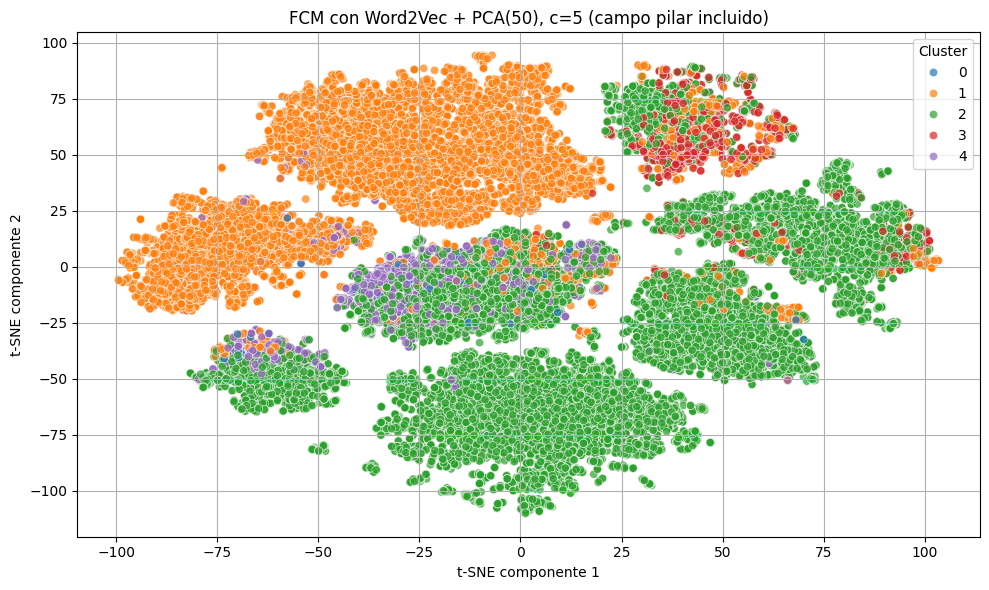

In [6]:
# ===========================================
# 5. Aplicar FCM con c=4 y c=5
# ===========================================
def aplicar_fcm_con_pilar(df_original, c=4):
    df = df_original.copy()
    modelo_w2v = Word2Vec(sentences=df["tokens"].tolist(), vector_size=100, window=3, min_count=1, sg=1, seed=42)
    df["vector"] = df["tokens"].apply(lambda x: vector_promedio(x, modelo_w2v))
    vectores = np.vstack(df["vector"].values)
    vectores_norm = normalize(vectores, norm='l2')
    pca = PCA(n_components=50, random_state=42)
    vectores_reducidos = pca.fit_transform(vectores_norm)
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(vectores_reducidos.T, c=c, m=1.5, error=0.005, maxiter=1000, seed=42)
    df[f"cluster_fcm_c{c}"] = np.argmax(u, axis=0)
    u_df = pd.DataFrame(u.T)

    resumen = []
    for i in range(c):
        indices = df[df[f"cluster_fcm_c{c}"] == i].index
        if len(indices) == 0:
            resumen.append({
                "Cluster": i,
                "N_iniciativas": 0,
                "Pertenencia_promedio": 0,
                "Desv": 0,
                "Min": 0,
                "Max": 0
            })
        else:
            pertenencias = u_df.iloc[indices, i]
            resumen.append({
                "Cluster": i,
                "N_iniciativas": len(indices),
                "Pertenencia_promedio": round(pertenencias.mean(), 6),
                "Desv": round(pertenencias.std(), 6),
                "Min": round(pertenencias.min(), 6),
                "Max": round(pertenencias.max(), 6)
            })

    tabla_resumen = pd.DataFrame(resumen)
    print(f"\n📋 Tabla resumen FCM con c={c}")
    print(tabla_resumen)

    # Visualización t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    tsne_result = tsne.fit_transform(vectores_reducidos)
    df["tsne_1"] = tsne_result[:, 0]
    df["tsne_2"] = tsne_result[:, 1]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x="tsne_1", y="tsne_2",
        hue=f"cluster_fcm_c{c}",
        data=df,
        palette="tab10",
        alpha=0.7
    )
    plt.title(f"FCM con Word2Vec + PCA(50), c={c} (campo pilar incluido)")
    plt.xlabel("t-SNE componente 1")
    plt.ylabel("t-SNE componente 2")
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df, tabla_resumen

# Aplicar y guardar
df_c4, tabla_c4 = aplicar_fcm_con_pilar(df_iniciativas, c=4)
df_c5, tabla_c5 = aplicar_fcm_con_pilar(df_iniciativas, c=5)


📋 Tabla cruzada: Pilar vs Cluster FCM (c=5)
cluster_fcm_c5                                       0     1     2     3     4
pilar                                                                         
1. ORDENAMIENTO SOCIAL DE LA PROPIEDAD RURAL Y ...   8   147  3099    34    28
2. INFRAESTRUCTURA Y ADECUACIÓN DE TIERRAS           0   126  3530   231     0
3. SALUD RURAL                                       4  3463    16     2    70
4. EDUCACIÓN RURAL Y PRIMERA INFANCIA RURAL          0  7067     2     1    18
5. VIVIENDA RURAL, AGUA POTABLE Y SANEAMIENTO B...   0   538  1057  1096     2
6. REACTIVACIÓN ECONÓMICA Y PRODUCCIÓN AGROPECU...   0     3  6084     0    14
7. SISTEMA PARA LA GARANTÍA PROGRESIVA DEL DERE...  28   118  1338     1   297
8. RECONCILIACIÓN, CONVIVENCIA Y CONSTRUCCIÓN D...  75   501  2864    42  1103


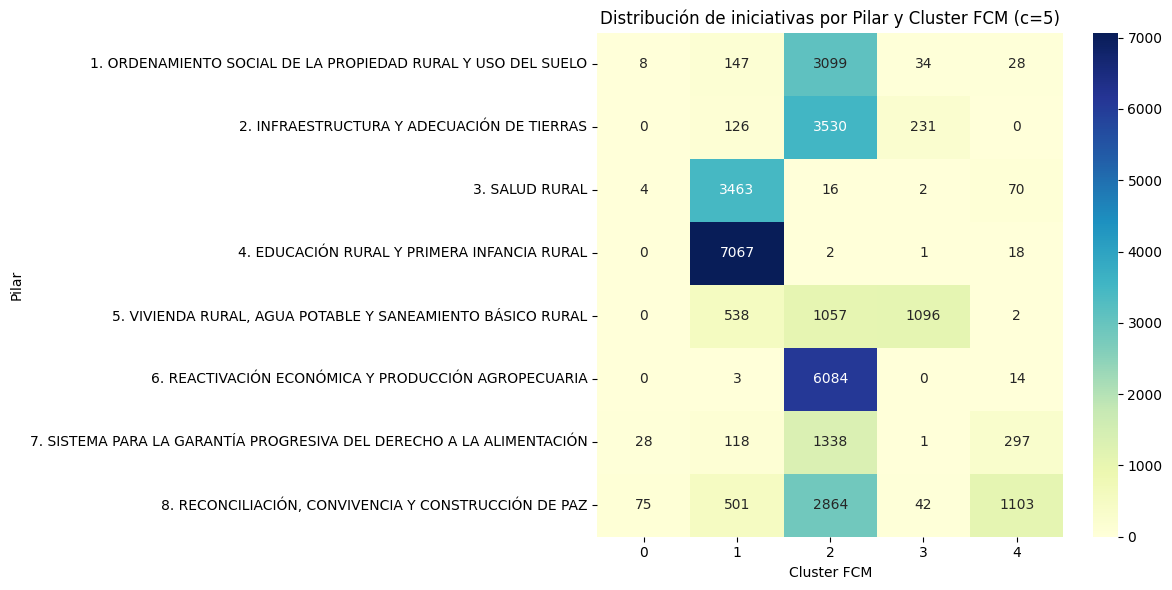

In [7]:
# Asegúrate de que df_c5 es el DataFrame con el resultado de c=5
# Y que contiene las columnas: 'pilar' y 'cluster_fcm_c5'

# Construir tabla cruzada
tabla_cruzada = pd.crosstab(df_c5["pilar"], df_c5["cluster_fcm_c5"])

# Mostrar tabla
print("\n📋 Tabla cruzada: Pilar vs Cluster FCM (c=5)")
print(tabla_cruzada)

# Visualizar heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(tabla_cruzada, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Distribución de iniciativas por Pilar y Cluster FCM (c=5)")
plt.xlabel("Cluster FCM")
plt.ylabel("Pilar")
plt.tight_layout()
plt.show()


In [8]:
# ===========================================
# 6. Vinculación semántica muchos a muchos
# ===========================================
dumbral_similitud = 0
if 'df_c5' in globals():
    df_iniciativas = df_iniciativas.merge(df_c5[["código_iniciativa", "cluster_fcm_c5"]], on="código_iniciativa", how="left")

dane_to_proyectos = defaultdict(list)
for _, p_row in df_proyectos.iterrows():
    for dane in p_row["codigos_dane_list"]:
        dane_to_proyectos[dane].append(p_row)

resultados = []
for _, i_row in tqdm(df_iniciativas.iterrows(), total=len(df_iniciativas), desc="Similitud Word2Vec con índice DANE"):
    dane_i = set(i_row["codigos_dane_list"])
    vector_i = i_row["vector"]
    clus_i = i_row.get("cluster_fcm_c5", None)
    comparados = set()

    for dane in dane_i:
        for p_row in dane_to_proyectos.get(dane, []):
            p_key = p_row["bpin"]
            if p_key in comparados:
                continue
            comparados.add(p_key)

            vector_p = p_row["vector"]
            sim = cosine_similarity([vector_i], [vector_p])[0][0]
            if sim >= dumbral_similitud:
                resultados.append({
                    "codigo_iniciativa": i_row["código_iniciativa"],
                    "cluster_iniciativa": clus_i,
                    "texto_iniciativa": i_row["texto_preprocesado"],
                    "bpin": p_row["bpin"],
                    "texto_proyecto": p_row["texto_preprocesado"],
                    "codigos_dane_compartidos": list(set(p_row["codigos_dane_list"]) & dane_i),
                    "similitud_coseno": round(sim, 4)
                })

# Resultados
df_matches_muchos_a_muchos = pd.DataFrame(resultados)

Similitud Word2Vec con índice DANE: 100%|██████████| 33007/33007 [3:06:22<00:00,  2.95it/s]    


In [13]:
df_matches_muchos_a_muchos.to_csv("vinculacion_semantica_resultados.csv", index=False, encoding='utf-8')


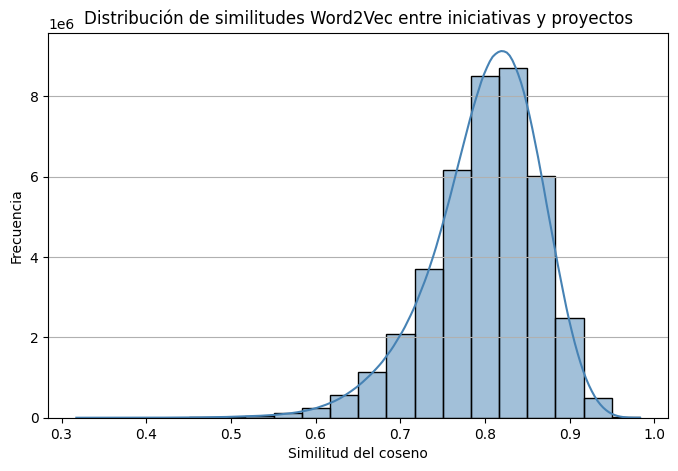

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(df_matches_muchos_a_muchos['similitud_coseno'], bins=20, kde=True, color='steelblue')
plt.title("Distribución de similitudes Word2Vec entre iniciativas y proyectos")
plt.xlabel("Similitud del coseno")
plt.ylabel("Frecuencia")
plt.grid(axis='y')

plt.show()

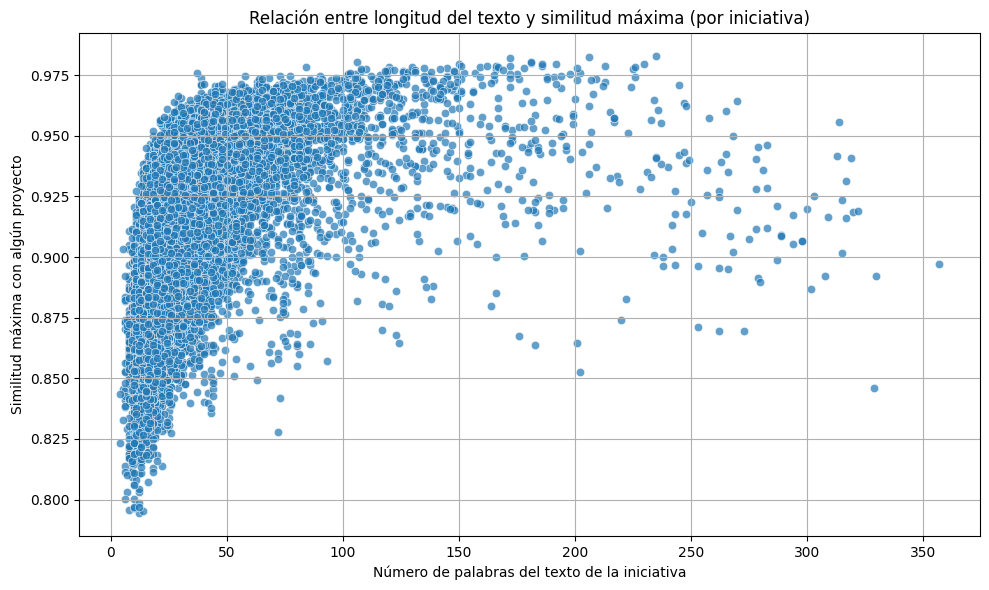

In [10]:
df_iniciativas['longitud_texto'] = df_iniciativas['texto_preprocesado'].astype(str).apply(lambda x: len(x.split()))
# Obtener la similitud máxima por iniciativa
df_max_sim = df_matches_muchos_a_muchos.groupby('codigo_iniciativa')['similitud_coseno'].max().reset_index()
df_max_sim = df_max_sim.merge(df_iniciativas[['código_iniciativa', 'longitud_texto']], left_on='codigo_iniciativa', right_on='código_iniciativa', how='left')

# Graficar
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_max_sim, x='longitud_texto', y='similitud_coseno', alpha=0.7)
plt.title("Relación entre longitud del texto y similitud máxima (por iniciativa)")
plt.xlabel("Número de palabras del texto de la iniciativa")
plt.ylabel("Similitud máxima con algún proyecto")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# ===========================================
# 7. Top coincidencias con filtro por umbral
# ===========================================
top_filtrados = df_matches_muchos_a_muchos[df_matches_muchos_a_muchos["similitud_coseno"] >= dumbral_similitud]
top_10 = top_filtrados.sort_values(by="similitud_coseno", ascending=False).head(10)

# Unir textos completos

top_10 = top_10.merge(
    df_iniciativas[["código_iniciativa", "texto_preprocesado"]],
    left_on="codigo_iniciativa",
    right_on="código_iniciativa",
    how="left"
).merge(
    df_proyectos[["bpin", "texto_preprocesado"]],
    on="bpin",
    how="left",
    suffixes=("_iniciativa", "_proyecto")
)

# Reorganizar y renombrar columnas

top_10 = top_10[[
    "codigo_iniciativa", "bpin", "cluster_iniciativa", "similitud_coseno",
    "texto_preprocesado_iniciativa", "texto_preprocesado_proyecto"
]]

top_10.rename(columns={
    "codigo_iniciativa": "Código Iniciativa",
    "bpin": "BPIN Proyecto",
    "cluster_iniciativa": "Cluster Iniciativa",
    "similitud_coseno": "Similitud Coseno",
    "texto_preprocesado_iniciativa": "Texto Iniciativa",
    "texto_preprocesado_proyecto": "Texto Proyecto"
}, inplace=True)

pd.set_option('display.max_colwidth', None)
display(top_10)


,Código Iniciativa,BPIN Proyecto,Cluster Iniciativa,Similitud Coseno,Texto Iniciativa,Texto Proyecto
0,119450291328,2022003190103,2,0.9830,fortalecer linea_productivo cacao establecimiento mantenimiento cultivo comercializacion cacao_tostado molido municipio_mercader cauca fortalecer linea_productivo cacao establecimiento mantenimiento cultivo comercializacion cacao_tostado molido municipio_mercader caucar siguiente accion promover cadena_productivo cacao familia productor suministro_insumos entrega_semilla mejorada conservacion_semilla nativo construccion vivero produccion material mejorado manejo_fitosanitario fermentacion beneficio equipo agricola fumigadora_guadana cava hoyo herramienta menor machete_palo pico capacitacion tecnificacion_agricola extension_rural eficiente proceso siembra produccion_comercializacion buscar sostenibilidad mercado miras desarrollo rural municipio planta tostadora cacao incluir plan funcionamiento procesamiento_transformacion cacao familia productor planta contar debido instalacion tecnologico maquinario utensilio adecuado proceso productivo tostadora molino bola prensadora moledora mezcladora masa empacadora asimismo deber dotar el estiba_secado almacenamiento dotacion vehiculo_transporte recoleccion cacao finca productor entregar planta_procesamiento paso requerir acompanamiento extension_agropecuario permanente proceso generacion_valor comercializacion mercado_local municipal regional asociatividad desarrollar componente_socioempresarial fortalecer pequeno_productor componente organizacion tecnico administrativo_financiero mercadeo_comercializacion garantizar adecuado gestion actividad productivo fortalecimiento ampliacion base social generacion servicio asociado cacao utilizar cultivo generador_ingreso conservacion medioambiental especie demandar cantidad agroquimico captador dioxido_carbono caracteristica permitir contribuir_reduccion gas_efecto invernadero principal responsable cambio_climatico demostrado siembra_cacao recuperan especie_fauna territorio cacao emplear zona estrategia sustitucion_cultivo ilicito implementar accion fortalecimiento_capacidad organizacional rural municipio_mercader cauco requerir apoyo organizacion municipio junto_accion comunal_asociacion productor consejo_comunitario fundacion_cooperativo poder contratar directamente jac entidad caracter_privado cooperacion_internacional ejecucion recurso proyecto involucrar lograr capacitacion proceso administrativo extension_rural formulacion ejecucion_proyecto social convocatoria caracter_regional nacional contribuir crecimiento dicho organizacion dotar_equipo computo_mobiliario funcionamiento generar crecimiento social_economico sector sentido requerir amnistia organizacion desconocimiento_norma encontrar reportada entidad diar_camara comercio ley cumplir el participacion jac,fortalecimiento produccion mora_castilla alto calidad departamento_caucir proyecto objetivo mejorar competitividad productor mora_castilla departamento_cauca suministro_material insumos proceso productivo mora_castilla acompanamiento profesional prestacion_servicio extension_agropecuario etapa productivo comercial buscar implementar fortalecida producir ano_tonelada beneficiar productor municipio beneficiado planta hectarea indicar ton mora_castilla alto calidad generar incremento_produccion lograr aplicacion plan adecuado fertilizacion_control plaga asistencia_tecnico redundacer incremento_rendimiento calidad mora obtenido contemplar implementacion taller_practico participativo tematico incluir demostracion_metodo etapa cultivo permitir incrementar competencia productor manejo_agronomico cultivo_mora sostenibilidad capacitar_beneficiario tematica indole comercial_agroindustria mejorar funcionamiento asociacion unidad_productivo taller dicho actividad permitir sistema produccion departamento sostenible plazo generar redito superior actualmente obtener ejercicio labor agropecuario ventaja adicional alternativa dotacion centro_acopio cuarto_frio local


📊 Distribución de correspondencias por cluster temático:
cluster_iniciativa
0      134033
1    14307820
2    22164785
3     1528054
4     2155922
Name: count, dtype: int64


C:\Users\balle\AppData\Local\Temp\ipykernel_7720\4155500895.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=distribucion_clusters.index, y=distribucion_clusters.values, palette="tab10")


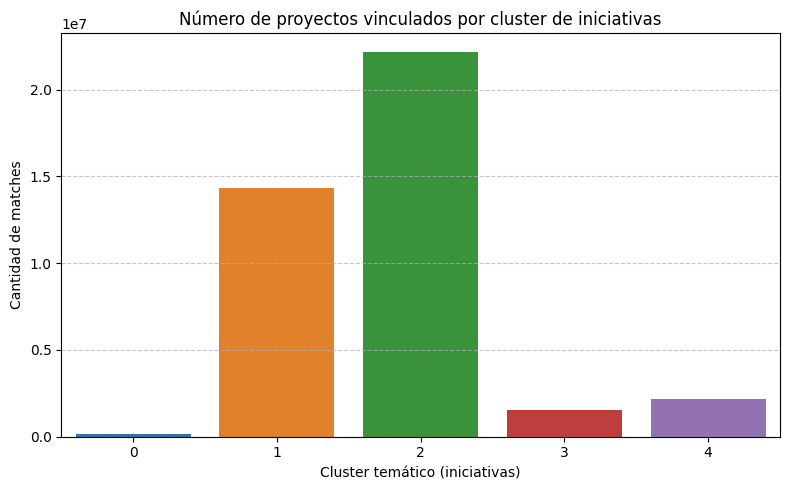

In [14]:

# Distribución de matches por cluster
distribucion_clusters = df_matches_muchos_a_muchos["cluster_iniciativa"].value_counts().sort_index()

# Mostrar en consola
print("\n📊 Distribución de correspondencias por cluster temático:")
print(distribucion_clusters)

# Graficar
plt.figure(figsize=(8, 5))
sns.barplot(x=distribucion_clusters.index, y=distribucion_clusters.values, palette="tab10")
plt.title("Número de proyectos vinculados por cluster de iniciativas")
plt.xlabel("Cluster temático (iniciativas)")
plt.ylabel("Cantidad de matches")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



📊 Distribución de matches por pilar PDET:


pilar
4. EDUCACIÓN RURAL Y PRIMERA INFANCIA RURAL                             8448198
6. REACTIVACIÓN ECONÓMICA Y PRODUCCIÓN AGROPECUARIA                     7524972
8. RECONCILIACIÓN, CONVIVENCIA Y CONSTRUCCIÓN DE PAZ                    5794290
2. INFRAESTRUCTURA Y ADECUACIÓN DE TIERRAS                              4597131
3. SALUD RURAL                                                          4322962
1. ORDENAMIENTO SOCIAL DE LA PROPIEDAD RURAL Y USO DEL SUELO            4189021
5. VIVIENDA RURAL, AGUA POTABLE Y SANEAMIENTO BÁSICO RURAL              3036920
7. SISTEMA PARA LA GARANTÍA PROGRESIVA DEL DERECHO A LA ALIMENTACIÓN    2377120
Name: count, dtype: int64

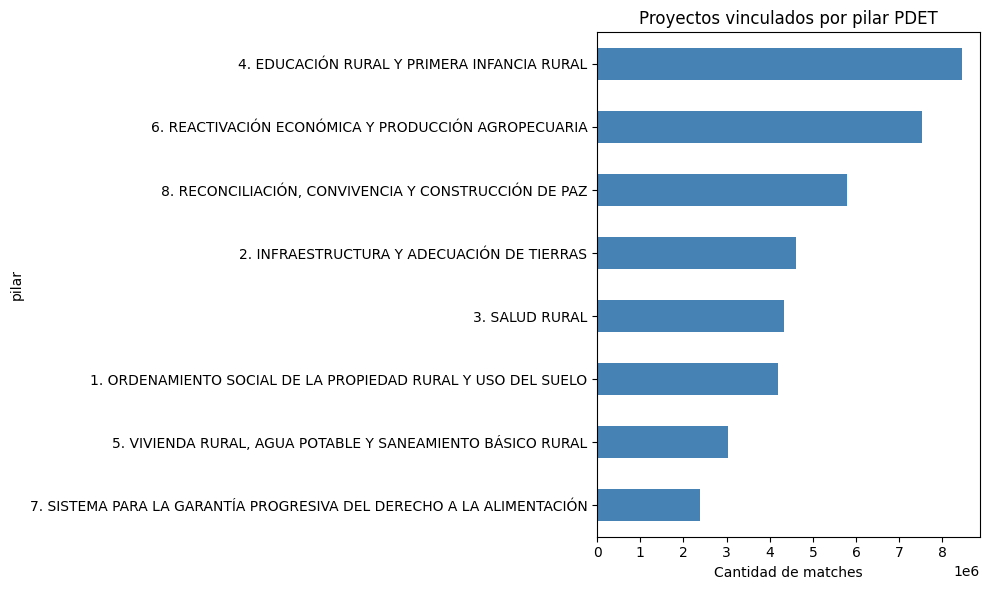

In [15]:
# Agrupar por pilar y contar
df_matches_pilar = df_matches_muchos_a_muchos.merge(
    df_iniciativas[["código_iniciativa", "pilar"]],
    left_on="codigo_iniciativa",
    right_on="código_iniciativa",
    how="left"
)

conteo_pilares = df_matches_pilar["pilar"].value_counts().sort_values(ascending=False)

# Mostrar tabla
print("\n📊 Distribución de matches por pilar PDET:")
display(conteo_pilares)

# Gráfico de barras horizontales
plt.figure(figsize=(10, 6))
conteo_pilares.plot(kind="barh", color="steelblue")
plt.title("Proyectos vinculados por pilar PDET")
plt.xlabel("Cantidad de matches")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
